# Setting configuration

In [3]:
import os
import time
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import optuna

config = {
    'BASE_DIR': r'C:\Users\stem\Downloads\merged_dataset\merged_dataset',
    'IMG_SIZE': 256,
    'EPOCHS': 15,
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    'NUM_CLASSES': 1,
    'PATIENCE': 5,
    'MIN_DELTA': 0.001
}

# Data preparation

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, base_dir, split='train'):
        self.image_dir = os.path.join(base_dir, split, 'images')
        self.mask_dir = os.path.join(base_dir, split, 'masks')

        self.image_files = sorted([f for f in os.listdir(self.image_dir)
                                   if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir)
                                  if f.endswith(('.png', '.jpg', '.jpeg'))])

        self.pairs = [(f, f) for f in self.image_files if f in self.mask_files]
        print(f"Loaded {len(self.pairs)} image-mask pairs for split '{split}'")

        self.image_transform = transforms.Compose([
            transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_name, mask_name = self.pairs[idx]
        image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, mask_name)).convert('L')
        return self.image_transform(image), self.mask_transform(mask)

# U-Net with ResNet34

In [12]:
class UNetResNet34(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        self.encoder0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.encoder1 = nn.Sequential(resnet.maxpool, resnet.layer1)
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.center = self.decoder_block(512, 256)
        self.decoder4 = self.decoder_block(256 + 256, 128)
        self.decoder3 = self.decoder_block(128 + 128, 64)
        self.decoder2 = self.decoder_block(64 + 64, 32)
        self.decoder1 = self.decoder_block(32 + 64, 16)
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e0 = self.encoder0(x)
        e1 = self.encoder1(e0)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        c = self.center(e4)
        d4 = self.decoder4(torch.cat([c, e3], dim=1))
        d3 = self.decoder3(torch.cat([d4, e2], dim=1))
        d2 = self.decoder2(torch.cat([d3, e1], dim=1))
        d1 = self.decoder1(torch.cat([d2, e0], dim=1))

        return self.final(d1)

# Metrices

In [13]:
class SegmentationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, preds, targets):
        return self.criterion(preds, targets)

In [14]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds_bin = (preds > threshold).float()
    targets_bin = (targets > threshold).float()

    intersection = (preds_bin * targets_bin).sum().item()
    union = preds_bin.sum().item() + targets_bin.sum().item() - intersection

    dice = (2. * intersection) / (preds_bin.sum().item() + targets_bin.sum().item() + 1e-6)
    iou = intersection / (union + 1e-6)
    accuracy = (preds_bin == targets_bin).float().mean().item()

    return dice, iou, accuracy

In [15]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for images, masks in tqdm(loader, desc='Training'):
        images, masks = images.to(config['DEVICE']), masks.to(config['DEVICE'])
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    total_dice, total_iou, total_acc = 0, 0, 0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc='Validation'):
            images, masks = images.to(config['DEVICE']), masks.to(config['DEVICE'])
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            dice, iou, acc = compute_metrics(outputs, masks)
            total_loss += loss.item()
            total_dice += dice
            total_iou += iou
            total_acc += acc

    num_batches = len(loader)
    return total_loss / num_batches, total_dice / num_batches, total_iou / num_batches, total_acc / num_batches

# hyperparameter tuning

In [56]:
def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [4, 8])

    print(f"\n Starting trial with lr={lr:.6f}, batch_size={batch_size}")

    train_dataset = SegmentationDataset(config['BASE_DIR'], 'train')
    val_dataset = SegmentationDataset(config['BASE_DIR'], 'val')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = UNetResNet34(num_classes=1).to(config['DEVICE'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = SegmentationLoss()

    best_loss = float('inf')
    best_dice = 0
    patience = 0

    for epoch in range(config['EPOCHS']):
        print(f"\n Epoch {epoch+1}/{config['EPOCHS']}")
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        val_loss, val_dice, val_iou, val_acc = validate(model, val_loader, loss_fn)

        print(f" Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f} | Acc: {val_acc:.4f}")

        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), 'best_model.pth')
            print(f" Saved new best model with Dice {val_dice:.4f}")

        if val_loss + config['MIN_DELTA'] < best_loss:
            best_loss = val_loss
            patience = 0
        else:
            patience += 1

        if patience >= config['PATIENCE']:
            print("Early stopping triggered")
            break

    return best_loss

In [58]:
if __name__ == '__main__':
    print("Starting Optuna tuning...")
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=5)
    print("Best trial:", study.best_trial.params)

[I 2025-05-20 12:52:31,514] A new study created in memory with name: no-name-ab2ae855-b82c-45d3-934d-ff289b645b0a


Starting Optuna tuning...

 Starting trial with lr=0.000200, batch_size=8
Loaded 2468 image-mask pairs for split 'train'
Loaded 530 image-mask pairs for split 'val'

 Epoch 1/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.14it/s]


 Train Loss: 0.3336 | Val Loss: 0.2416 | Dice: 0.7602 | IoU: 0.6323 | Acc: 0.9732
 Saved new best model with Dice 0.7602

 Epoch 2/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.20it/s]


 Train Loss: 0.2088 | Val Loss: 0.1674 | Dice: 0.8238 | IoU: 0.7128 | Acc: 0.9783
 Saved new best model with Dice 0.8238

 Epoch 3/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.20it/s]


 Train Loss: 0.1490 | Val Loss: 0.1337 | Dice: 0.7935 | IoU: 0.6717 | Acc: 0.9736

 Epoch 4/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  8.99it/s]


 Train Loss: 0.1097 | Val Loss: 0.1003 | Dice: 0.8236 | IoU: 0.7156 | Acc: 0.9781

 Epoch 5/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.12it/s]


 Train Loss: 0.0838 | Val Loss: 0.0900 | Dice: 0.8273 | IoU: 0.7196 | Acc: 0.9783
 Saved new best model with Dice 0.8273

 Epoch 6/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.11it/s]


 Train Loss: 0.0661 | Val Loss: 0.0865 | Dice: 0.8156 | IoU: 0.7045 | Acc: 0.9754

 Epoch 7/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.15it/s]


 Train Loss: 0.0537 | Val Loss: 0.0766 | Dice: 0.8173 | IoU: 0.7145 | Acc: 0.9791

 Epoch 8/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.14it/s]


 Train Loss: 0.0430 | Val Loss: 0.0735 | Dice: 0.8253 | IoU: 0.7179 | Acc: 0.9746

 Epoch 9/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.18it/s]


 Train Loss: 0.0465 | Val Loss: 0.0722 | Dice: 0.8202 | IoU: 0.7100 | Acc: 0.9773

 Epoch 10/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.17it/s]


 Train Loss: 0.0363 | Val Loss: 0.0622 | Dice: 0.8493 | IoU: 0.7536 | Acc: 0.9817
 Saved new best model with Dice 0.8493

 Epoch 11/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.13it/s]


 Train Loss: 0.0313 | Val Loss: 0.0722 | Dice: 0.8227 | IoU: 0.7161 | Acc: 0.9765

 Epoch 12/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.27it/s]


 Train Loss: 0.0306 | Val Loss: 0.0618 | Dice: 0.8431 | IoU: 0.7449 | Acc: 0.9799

 Epoch 13/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.09it/s]


 Train Loss: 0.0270 | Val Loss: 0.0569 | Dice: 0.8662 | IoU: 0.7751 | Acc: 0.9830
 Saved new best model with Dice 0.8662

 Epoch 14/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.20it/s]


 Train Loss: 0.0196 | Val Loss: 0.0587 | Dice: 0.8672 | IoU: 0.7779 | Acc: 0.9828
 Saved new best model with Dice 0.8672

 Epoch 15/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.10it/s]
[I 2025-05-20 13:08:37,589] Trial 0 finished with value: 0.056884505994506736 and parameters: {'lr': 0.0001996502234962369, 'batch_size': 8}. Best is trial 0 with value: 0.056884505994506736.


 Train Loss: 0.0173 | Val Loss: 0.0604 | Dice: 0.8719 | IoU: 0.7846 | Acc: 0.9828
 Saved new best model with Dice 0.8719

 Starting trial with lr=0.000021, batch_size=4
Loaded 2468 image-mask pairs for split 'train'
Loaded 530 image-mask pairs for split 'val'

 Epoch 1/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.75it/s]


 Train Loss: 0.4119 | Val Loss: 0.3270 | Dice: 0.7473 | IoU: 0.6194 | Acc: 0.9685
 Saved new best model with Dice 0.7473

 Epoch 2/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.45it/s]


 Train Loss: 0.3076 | Val Loss: 0.2834 | Dice: 0.8014 | IoU: 0.6901 | Acc: 0.9774
 Saved new best model with Dice 0.8014

 Epoch 3/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.76it/s]


 Train Loss: 0.2687 | Val Loss: 0.2577 | Dice: 0.8127 | IoU: 0.7080 | Acc: 0.9772
 Saved new best model with Dice 0.8127

 Epoch 4/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.66it/s]


 Train Loss: 0.2400 | Val Loss: 0.2338 | Dice: 0.8310 | IoU: 0.7323 | Acc: 0.9791
 Saved new best model with Dice 0.8310

 Epoch 5/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.49it/s]


 Train Loss: 0.2172 | Val Loss: 0.2167 | Dice: 0.8267 | IoU: 0.7246 | Acc: 0.9780

 Epoch 6/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.70it/s]


 Train Loss: 0.1947 | Val Loss: 0.2002 | Dice: 0.8400 | IoU: 0.7435 | Acc: 0.9801
 Saved new best model with Dice 0.8400

 Epoch 7/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.42it/s]


 Train Loss: 0.1755 | Val Loss: 0.1792 | Dice: 0.8372 | IoU: 0.7407 | Acc: 0.9811

 Epoch 8/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.15it/s]


 Train Loss: 0.1595 | Val Loss: 0.1646 | Dice: 0.8448 | IoU: 0.7523 | Acc: 0.9811
 Saved new best model with Dice 0.8448

 Epoch 9/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.66it/s]


 Train Loss: 0.1431 | Val Loss: 0.1591 | Dice: 0.8437 | IoU: 0.7500 | Acc: 0.9805

 Epoch 10/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.28it/s]


 Train Loss: 0.1277 | Val Loss: 0.1429 | Dice: 0.8484 | IoU: 0.7574 | Acc: 0.9810
 Saved new best model with Dice 0.8484

 Epoch 11/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.41it/s]


 Train Loss: 0.1152 | Val Loss: 0.1321 | Dice: 0.8474 | IoU: 0.7569 | Acc: 0.9814

 Epoch 12/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.69it/s]


 Train Loss: 0.1030 | Val Loss: 0.1227 | Dice: 0.8490 | IoU: 0.7582 | Acc: 0.9808
 Saved new best model with Dice 0.8490

 Epoch 13/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.09it/s]


 Train Loss: 0.0927 | Val Loss: 0.1199 | Dice: 0.8444 | IoU: 0.7520 | Acc: 0.9800

 Epoch 14/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.49it/s]


 Train Loss: 0.0832 | Val Loss: 0.1081 | Dice: 0.8558 | IoU: 0.7683 | Acc: 0.9819
 Saved new best model with Dice 0.8558

 Epoch 15/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.74it/s]
[I 2025-05-20 13:27:15,124] Trial 1 finished with value: 0.1034156009554863 and parameters: {'lr': 2.1285720923440147e-05, 'batch_size': 4}. Best is trial 0 with value: 0.056884505994506736.


 Train Loss: 0.0743 | Val Loss: 0.1034 | Dice: 0.8559 | IoU: 0.7678 | Acc: 0.9819
 Saved new best model with Dice 0.8559

 Starting trial with lr=0.000169, batch_size=4
Loaded 2468 image-mask pairs for split 'train'
Loaded 530 image-mask pairs for split 'val'

 Epoch 1/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.21it/s]


 Train Loss: 0.4417 | Val Loss: 0.3263 | Dice: 0.7255 | IoU: 0.5968 | Acc: 0.9580
 Saved new best model with Dice 0.7255

 Epoch 2/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.39it/s]


 Train Loss: 0.2533 | Val Loss: 0.1842 | Dice: 0.7806 | IoU: 0.6648 | Acc: 0.9760
 Saved new best model with Dice 0.7806

 Epoch 3/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.66it/s]


 Train Loss: 0.1606 | Val Loss: 0.1293 | Dice: 0.7855 | IoU: 0.6737 | Acc: 0.9764
 Saved new best model with Dice 0.7855

 Epoch 4/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.21it/s]


 Train Loss: 0.1096 | Val Loss: 0.1909 | Dice: 0.6723 | IoU: 0.5341 | Acc: 0.9355

 Epoch 5/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.57it/s]


 Train Loss: 0.0817 | Val Loss: 0.0817 | Dice: 0.8050 | IoU: 0.7043 | Acc: 0.9785
 Saved new best model with Dice 0.8050

 Epoch 6/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.50it/s]


 Train Loss: 0.0647 | Val Loss: 0.0739 | Dice: 0.8057 | IoU: 0.7066 | Acc: 0.9757
 Saved new best model with Dice 0.8057

 Epoch 7/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.25it/s]


 Train Loss: 0.0506 | Val Loss: 0.0621 | Dice: 0.8322 | IoU: 0.7403 | Acc: 0.9813
 Saved new best model with Dice 0.8322

 Epoch 8/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.74it/s]


 Train Loss: 0.0477 | Val Loss: 0.0624 | Dice: 0.8305 | IoU: 0.7343 | Acc: 0.9811

 Epoch 9/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.76it/s]


 Train Loss: 0.0390 | Val Loss: 0.0576 | Dice: 0.8478 | IoU: 0.7568 | Acc: 0.9822
 Saved new best model with Dice 0.8478

 Epoch 10/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.24it/s]


 Train Loss: 0.0318 | Val Loss: 0.0587 | Dice: 0.8483 | IoU: 0.7587 | Acc: 0.9818
 Saved new best model with Dice 0.8483

 Epoch 11/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.62it/s]


 Train Loss: 0.0248 | Val Loss: 0.0618 | Dice: 0.8308 | IoU: 0.7358 | Acc: 0.9816

 Epoch 12/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.68it/s]


 Train Loss: 0.0247 | Val Loss: 0.0632 | Dice: 0.8204 | IoU: 0.7212 | Acc: 0.9797

 Epoch 13/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 16.80it/s]


 Train Loss: 0.0368 | Val Loss: 0.0650 | Dice: 0.8306 | IoU: 0.7367 | Acc: 0.9808

 Epoch 14/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.34it/s]
[I 2025-05-20 13:44:37,544] Trial 2 finished with value: 0.05755988733941003 and parameters: {'lr': 0.00016941746038561737, 'batch_size': 4}. Best is trial 0 with value: 0.056884505994506736.


 Train Loss: 0.0225 | Val Loss: 0.0593 | Dice: 0.8457 | IoU: 0.7571 | Acc: 0.9824
Early stopping triggered

 Starting trial with lr=0.000018, batch_size=4
Loaded 2468 image-mask pairs for split 'train'
Loaded 530 image-mask pairs for split 'val'

 Epoch 1/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.71it/s]


 Train Loss: 0.6595 | Val Loss: 0.5788 | Dice: 0.6035 | IoU: 0.4503 | Acc: 0.9385
 Saved new best model with Dice 0.6035

 Epoch 2/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.37it/s]


 Train Loss: 0.5545 | Val Loss: 0.5326 | Dice: 0.7710 | IoU: 0.6485 | Acc: 0.9727
 Saved new best model with Dice 0.7710

 Epoch 3/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.91it/s]


 Train Loss: 0.5167 | Val Loss: 0.5026 | Dice: 0.7925 | IoU: 0.6779 | Acc: 0.9758
 Saved new best model with Dice 0.7925

 Epoch 4/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.15it/s]


 Train Loss: 0.4856 | Val Loss: 0.4812 | Dice: 0.7816 | IoU: 0.6663 | Acc: 0.9702

 Epoch 5/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.36it/s]


 Train Loss: 0.4573 | Val Loss: 0.4491 | Dice: 0.8141 | IoU: 0.7108 | Acc: 0.9773
 Saved new best model with Dice 0.8141

 Epoch 6/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.64it/s]


 Train Loss: 0.4306 | Val Loss: 0.4247 | Dice: 0.8276 | IoU: 0.7315 | Acc: 0.9802
 Saved new best model with Dice 0.8276

 Epoch 7/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.05it/s]


 Train Loss: 0.4055 | Val Loss: 0.3990 | Dice: 0.8307 | IoU: 0.7325 | Acc: 0.9803
 Saved new best model with Dice 0.8307

 Epoch 8/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.33it/s]


 Train Loss: 0.3819 | Val Loss: 0.3869 | Dice: 0.8397 | IoU: 0.7455 | Acc: 0.9808
 Saved new best model with Dice 0.8397

 Epoch 9/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.76it/s]


 Train Loss: 0.3590 | Val Loss: 0.3950 | Dice: 0.7567 | IoU: 0.6321 | Acc: 0.9661

 Epoch 10/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.36it/s]


 Train Loss: 0.3387 | Val Loss: 0.3414 | Dice: 0.8448 | IoU: 0.7526 | Acc: 0.9819
 Saved new best model with Dice 0.8448

 Epoch 11/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.44it/s]


 Train Loss: 0.3173 | Val Loss: 0.3164 | Dice: 0.8360 | IoU: 0.7370 | Acc: 0.9809

 Epoch 12/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.34it/s]


 Train Loss: 0.2972 | Val Loss: 0.3083 | Dice: 0.8378 | IoU: 0.7419 | Acc: 0.9798

 Epoch 13/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.25it/s]


 Train Loss: 0.2772 | Val Loss: 0.2857 | Dice: 0.8558 | IoU: 0.7654 | Acc: 0.9823
 Saved new best model with Dice 0.8558

 Epoch 14/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.44it/s]


 Train Loss: 0.2599 | Val Loss: 0.2658 | Dice: 0.8510 | IoU: 0.7609 | Acc: 0.9825

 Epoch 15/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.62it/s]
[I 2025-05-20 14:03:17,061] Trial 3 finished with value: 0.2570966436226565 and parameters: {'lr': 1.784391189107324e-05, 'batch_size': 4}. Best is trial 0 with value: 0.056884505994506736.


 Train Loss: 0.2421 | Val Loss: 0.2571 | Dice: 0.8513 | IoU: 0.7609 | Acc: 0.9809

 Starting trial with lr=0.000022, batch_size=4
Loaded 2468 image-mask pairs for split 'train'
Loaded 530 image-mask pairs for split 'val'

 Epoch 1/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.40it/s]


 Train Loss: 0.4993 | Val Loss: 0.4299 | Dice: 0.7592 | IoU: 0.6327 | Acc: 0.9715
 Saved new best model with Dice 0.7592

 Epoch 2/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.44it/s]


 Train Loss: 0.4167 | Val Loss: 0.3934 | Dice: 0.8024 | IoU: 0.6882 | Acc: 0.9771
 Saved new best model with Dice 0.8024

 Epoch 3/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.96it/s]


 Train Loss: 0.3785 | Val Loss: 0.3590 | Dice: 0.8236 | IoU: 0.7205 | Acc: 0.9804
 Saved new best model with Dice 0.8236

 Epoch 4/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.23it/s]


 Train Loss: 0.3468 | Val Loss: 0.3372 | Dice: 0.8278 | IoU: 0.7260 | Acc: 0.9791
 Saved new best model with Dice 0.8278

 Epoch 5/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.43it/s]


 Train Loss: 0.3182 | Val Loss: 0.3087 | Dice: 0.8418 | IoU: 0.7442 | Acc: 0.9808
 Saved new best model with Dice 0.8418

 Epoch 6/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.60it/s]


 Train Loss: 0.2916 | Val Loss: 0.2893 | Dice: 0.8412 | IoU: 0.7443 | Acc: 0.9802

 Epoch 7/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.23it/s]


 Train Loss: 0.2681 | Val Loss: 0.2684 | Dice: 0.8432 | IoU: 0.7475 | Acc: 0.9817
 Saved new best model with Dice 0.8432

 Epoch 8/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.34it/s]


 Train Loss: 0.2451 | Val Loss: 0.2492 | Dice: 0.8453 | IoU: 0.7502 | Acc: 0.9798
 Saved new best model with Dice 0.8453

 Epoch 9/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.51it/s]


 Train Loss: 0.2243 | Val Loss: 0.2293 | Dice: 0.8557 | IoU: 0.7642 | Acc: 0.9820
 Saved new best model with Dice 0.8557

 Epoch 10/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.21it/s]


 Train Loss: 0.2042 | Val Loss: 0.2140 | Dice: 0.8502 | IoU: 0.7570 | Acc: 0.9810

 Epoch 11/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.19it/s]


 Train Loss: 0.1886 | Val Loss: 0.2023 | Dice: 0.8477 | IoU: 0.7523 | Acc: 0.9806

 Epoch 12/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.67it/s]


 Train Loss: 0.1698 | Val Loss: 0.1860 | Dice: 0.8538 | IoU: 0.7622 | Acc: 0.9815

 Epoch 13/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.33it/s]


 Train Loss: 0.1549 | Val Loss: 0.1712 | Dice: 0.8548 | IoU: 0.7631 | Acc: 0.9821

 Epoch 14/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.51it/s]


 Train Loss: 0.1400 | Val Loss: 0.1583 | Dice: 0.8650 | IoU: 0.7777 | Acc: 0.9832
 Saved new best model with Dice 0.8650

 Epoch 15/15


Validation: 100%|██████████| 133/133 [00:07<00:00, 17.51it/s]
[I 2025-05-20 14:21:57,824] Trial 4 finished with value: 0.1462850460880681 and parameters: {'lr': 2.248803131464717e-05, 'batch_size': 4}. Best is trial 0 with value: 0.056884505994506736.


 Train Loss: 0.1267 | Val Loss: 0.1463 | Dice: 0.8438 | IoU: 0.7510 | Acc: 0.9824
Best trial: {'lr': 0.0001996502234962369, 'batch_size': 8}


# Model evaluation

In [59]:
test_dataset = SegmentationDataset(config['BASE_DIR'], 'test')
test_loader = DataLoader(test_dataset, batch_size=best_batch_size)

test_loss, test_dice, test_iou, test_acc = 0, 0, 0, 0

model.load_state_dict(torch.load('best_model.pth', map_location=config['DEVICE']))
model.eval()

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc='Testing'):
        images, masks = images.to(config['DEVICE']), masks.to(config['DEVICE'])
        outputs = model(images)
        loss = loss_fn(outputs, masks)

        test_loss += loss.item()
        d, i, a = compute_metrics(outputs, masks)
        test_dice += d
        test_iou += i
        test_acc += a

num_batches = len(test_loader)
test_loss /= num_batches
test_dice /= num_batches
test_iou /= num_batches
test_acc /= num_batches

print("\n--- Test Evaluation ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Dice: {test_dice:.4f}")
print(f"Test IoU : {test_iou:.4f}")
print(f"Test Acc : {test_acc:.4f}")

C:\Users\stem\AppData\Local\Temp\ipykernel_7668\3291979685.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_locatio

Loaded 530 image-mask pairs for split 'test'


Testing: 100%|██████████| 133/133 [00:07<00:00, 16.69it/s]


--- Test Evaluation ---
Test Loss: 0.1549
Test Dice: 0.8840
Test IoU : 0.8039
Test Acc : 0.9848


Loaded 2468 image-mask pairs for split 'train'
Loaded 530 image-mask pairs for split 'val'


C:\Users\stem\AppData\Local\Temp\ipykernel_7668\367301257.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_locatio


Starting final training with best hyperparameters...


Epoch 1/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.22it/s]


Train Loss: 0.1373 | Val Loss: 0.1161
Train Dice: 0.8551 | Val Dice: 0.8164
Train IoU : 0.7561 | Val IoU : 0.7052
Train Acc : 0.9784 | Val Acc : 0.9781

Epoch 2/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.22it/s]


Train Loss: 0.0984 | Val Loss: 0.1061
Train Dice: 0.8777 | Val Dice: 0.8068
Train IoU : 0.7893 | Val IoU : 0.6899
Train Acc : 0.9815 | Val Acc : 0.9746

Epoch 3/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.19it/s]


Train Loss: 0.0777 | Val Loss: 0.0808
Train Dice: 0.8822 | Val Dice: 0.8346
Train IoU : 0.7973 | Val IoU : 0.7293
Train Acc : 0.9826 | Val Acc : 0.9782

Epoch 4/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.13it/s]


Train Loss: 0.0628 | Val Loss: 0.0704
Train Dice: 0.8967 | Val Dice: 0.8501
Train IoU : 0.8188 | Val IoU : 0.7511
Train Acc : 0.9846 | Val Acc : 0.9806

Epoch 5/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.26it/s]


Train Loss: 0.0440 | Val Loss: 0.0687
Train Dice: 0.9295 | Val Dice: 0.8462
Train IoU : 0.8703 | Val IoU : 0.7482
Train Acc : 0.9895 | Val Acc : 0.9793

Epoch 6/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.18it/s]


Train Loss: 0.0395 | Val Loss: 0.0830
Train Dice: 0.9292 | Val Dice: 0.8043
Train IoU : 0.8710 | Val IoU : 0.6877
Train Acc : 0.9896 | Val Acc : 0.9729

Epoch 7/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.23it/s]


Train Loss: 0.0407 | Val Loss: 0.0691
Train Dice: 0.9172 | Val Dice: 0.8382
Train IoU : 0.8514 | Val IoU : 0.7377
Train Acc : 0.9880 | Val Acc : 0.9793

Epoch 8/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.30it/s]


Train Loss: 0.0371 | Val Loss: 0.0666
Train Dice: 0.9219 | Val Dice: 0.8261
Train IoU : 0.8589 | Val IoU : 0.7182
Train Acc : 0.9886 | Val Acc : 0.9784

Epoch 9/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.35it/s]


Train Loss: 0.0287 | Val Loss: 0.0602
Train Dice: 0.9410 | Val Dice: 0.8568
Train IoU : 0.8900 | Val IoU : 0.7606
Train Acc : 0.9913 | Val Acc : 0.9812

Epoch 10/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.31it/s]


Train Loss: 0.0404 | Val Loss: 0.0704
Train Dice: 0.9101 | Val Dice: 0.7949
Train IoU : 0.8395 | Val IoU : 0.6802
Train Acc : 0.9865 | Val Acc : 0.9774

Epoch 11/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.09it/s]


Train Loss: 0.0344 | Val Loss: 0.0787
Train Dice: 0.9215 | Val Dice: 0.8103
Train IoU : 0.8597 | Val IoU : 0.6945
Train Acc : 0.9888 | Val Acc : 0.9730

Epoch 12/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.23it/s]


Train Loss: 0.0291 | Val Loss: 0.0545
Train Dice: 0.9316 | Val Dice: 0.8615
Train IoU : 0.8750 | Val IoU : 0.7716
Train Acc : 0.9901 | Val Acc : 0.9829

Epoch 13/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.22it/s]


Train Loss: 0.0195 | Val Loss: 0.0628
Train Dice: 0.9555 | Val Dice: 0.8567
Train IoU : 0.9154 | Val IoU : 0.7644
Train Acc : 0.9935 | Val Acc : 0.9814

Epoch 14/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.28it/s]


Train Loss: 0.0163 | Val Loss: 0.0605
Train Dice: 0.9627 | Val Dice: 0.8678
Train IoU : 0.9284 | Val IoU : 0.7791
Train Acc : 0.9946 | Val Acc : 0.9831

Epoch 15/15


Validation: 100%|██████████| 67/67 [00:07<00:00,  9.23it/s]


Train Loss: 0.0142 | Val Loss: 0.0623
Train Dice: 0.9662 | Val Dice: 0.8679
Train IoU : 0.9349 | Val IoU : 0.7807
Train Acc : 0.9951 | Val Acc : 0.9833


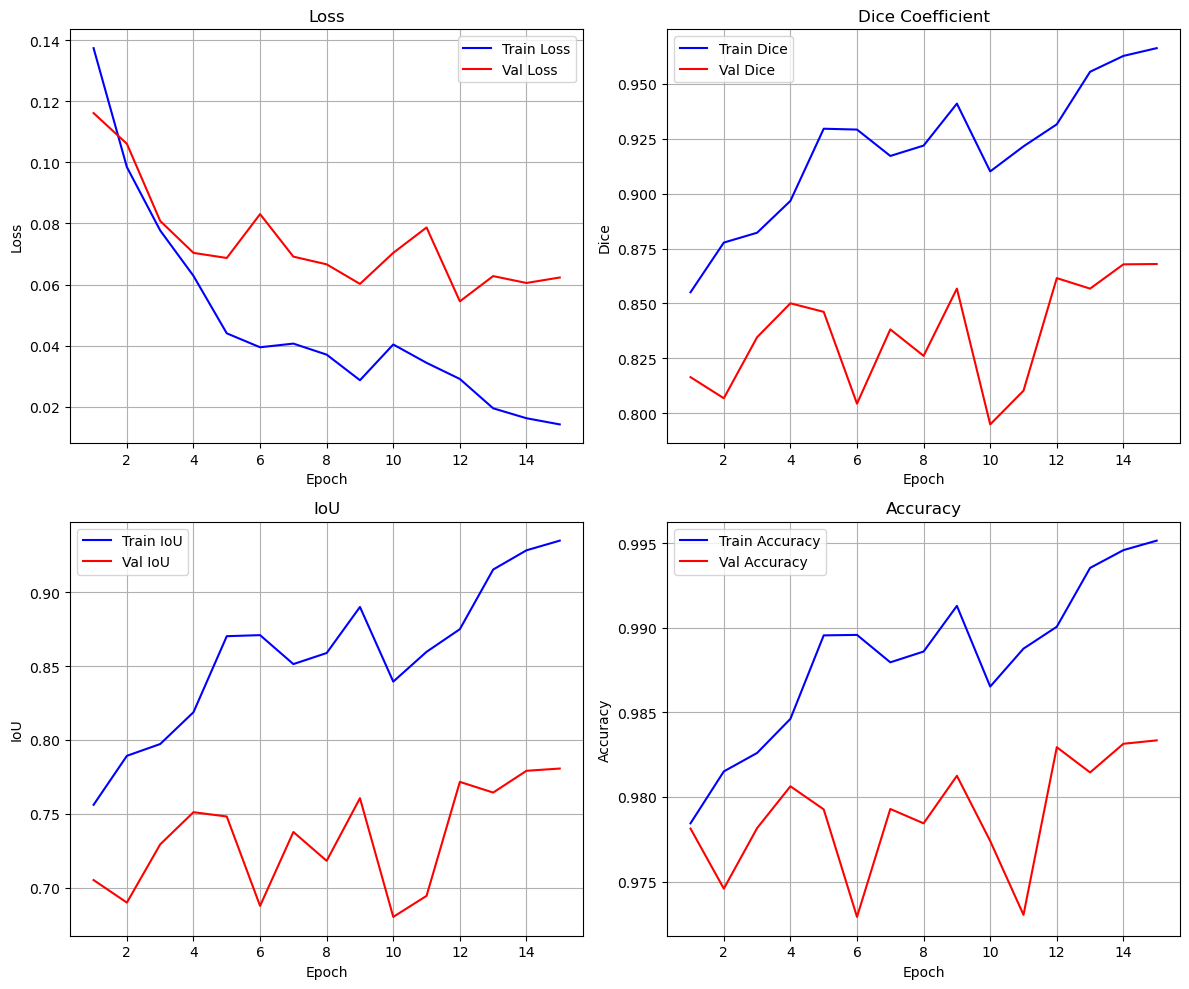

In [63]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

best_lr = 0.0001996502234962369
best_batch_size = 8

train_dataset = SegmentationDataset(config['BASE_DIR'], 'train')
val_dataset = SegmentationDataset(config['BASE_DIR'], 'val')
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size)

model = UNetResNet34(num_classes=1).to(config['DEVICE'])
model.load_state_dict(torch.load('best_model.pth', map_location=config['DEVICE'])) 
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
loss_fn = SegmentationLoss()

train_losses, val_losses = [], []
train_dices, val_dices = [], []
train_ious, val_ious = [], []
train_accs, val_accs = [], []

print("\nStarting final training with best hyperparameters...\n")

for epoch in range(15):  # 15 эпох
    print(f"\nEpoch {epoch + 1}/15")

    model.train()
    train_loss, train_dice, train_iou, train_acc = 0, 0, 0, 0
    for images, masks in tqdm(train_loader, desc='Training'):
        images, masks = images.to(config['DEVICE']), masks.to(config['DEVICE'])
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        d, i, a = compute_metrics(outputs, masks)
        train_dice += d
        train_iou += i
        train_acc += a

    num_train_batches = len(train_loader)
    train_losses.append(train_loss / num_train_batches)
    train_dices.append(train_dice / num_train_batches)
    train_ious.append(train_iou / num_train_batches)
    train_accs.append(train_acc / num_train_batches)

    val_loss, val_dice, val_iou, val_acc = validate(model, val_loader, loss_fn)
    val_losses.append(val_loss)
    val_dices.append(val_dice)
    val_ious.append(val_iou)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Dice: {train_dices[-1]:.4f} | Val Dice: {val_dice:.4f}")
    print(f"Train IoU : {train_ious[-1]:.4f} | Val IoU : {val_iou:.4f}")
    print(f"Train Acc : {train_accs[-1]:.4f} | Val Acc : {val_acc:.4f}")

epochs = range(1, 16)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, train_dices, 'b-', label='Train Dice')
plt.plot(epochs, val_dices, 'r-', label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, train_ious, 'b-', label='Train IoU')
plt.plot(epochs, val_ious, 'r-', label='Val IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accs, 'r-', label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

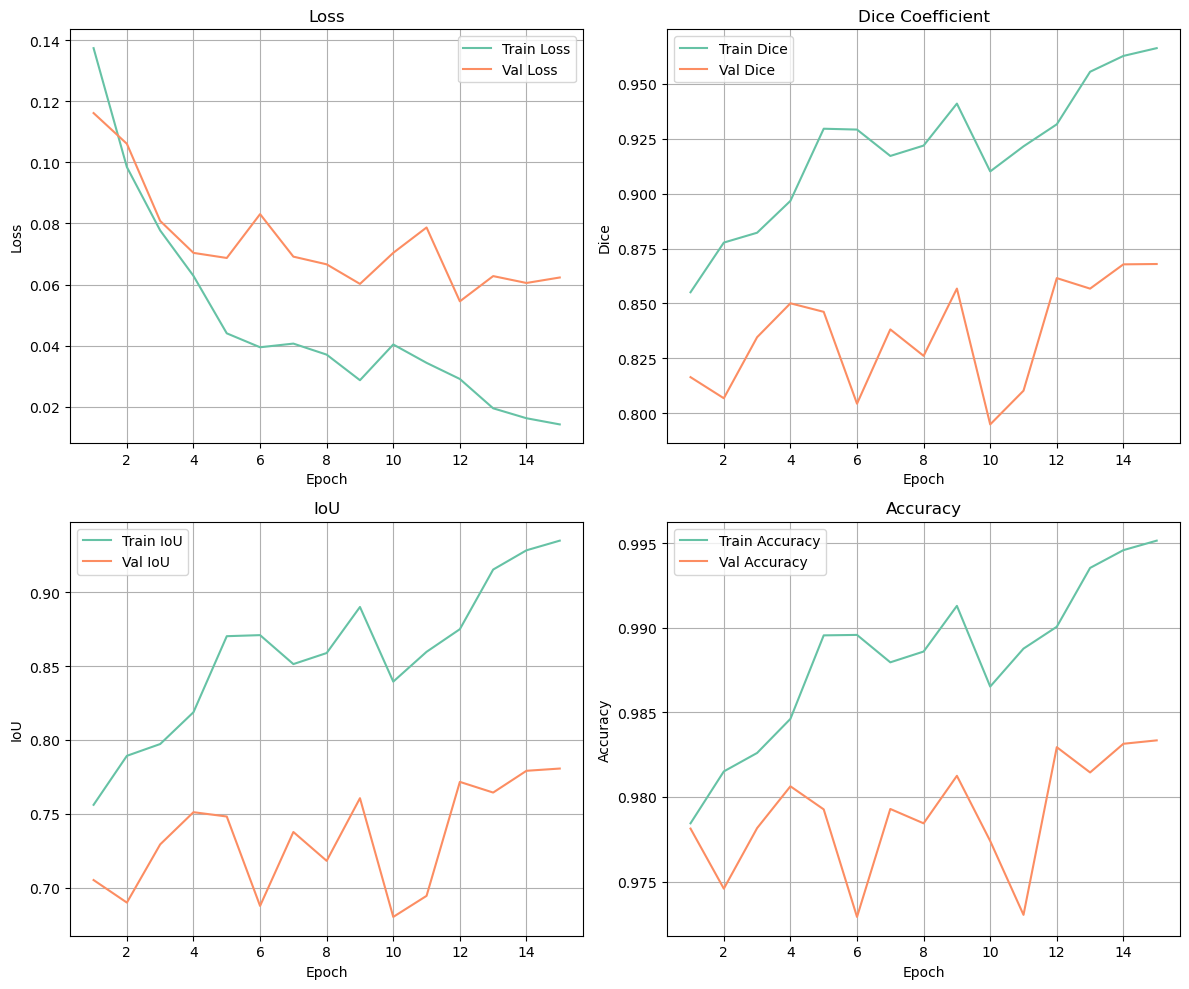

In [68]:
epochs = range(1, 16)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, color='#66c2a5', label='Train Loss') 
plt.plot(epochs, val_losses, color='#fc8d62', label='Val Loss')      
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, train_dices, color='#66c2a5', label='Train Dice')
plt.plot(epochs, val_dices, color='#fc8d62', label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, train_ious, color='#66c2a5', label='Train IoU')
plt.plot(epochs, val_ious, color='#fc8d62', label='Val IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs, train_accs, color='#66c2a5', label='Train Accuracy')
plt.plot(epochs, val_accs, color='#fc8d62', label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [64]:
import pandas as pd

metrics_data = {
    'Loss': [sum(train_losses) / len(train_losses), sum(val_losses) / len(val_losses)],
    'Dice': [sum(train_dices) / len(train_dices), sum(val_dices) / len(val_dices)],
    'IoU': [sum(train_ious) / len(train_ious), sum(val_ious) / len(val_ious)],
    'Accuracy': [sum(train_accs) / len(train_accs), sum(val_accs) / len(val_accs)],
}

df_metrics = pd.DataFrame(metrics_data, index=['Train', 'Val'])

print("\n Average Metrics Over 15 Epochs")
display(df_metrics)


 Average Metrics Over 15 Epochs


,Loss,Dice,IoU,Accuracy
Train,0.048012,0.919870,0.857061,0.988179
Val,0.074011,0.835911,0.733239,0.978930


# Visualizations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


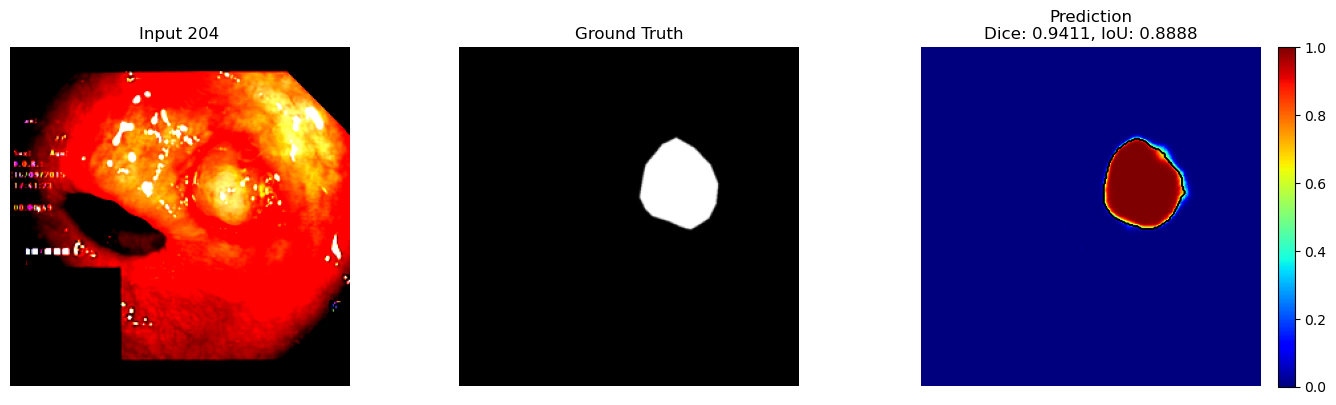

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


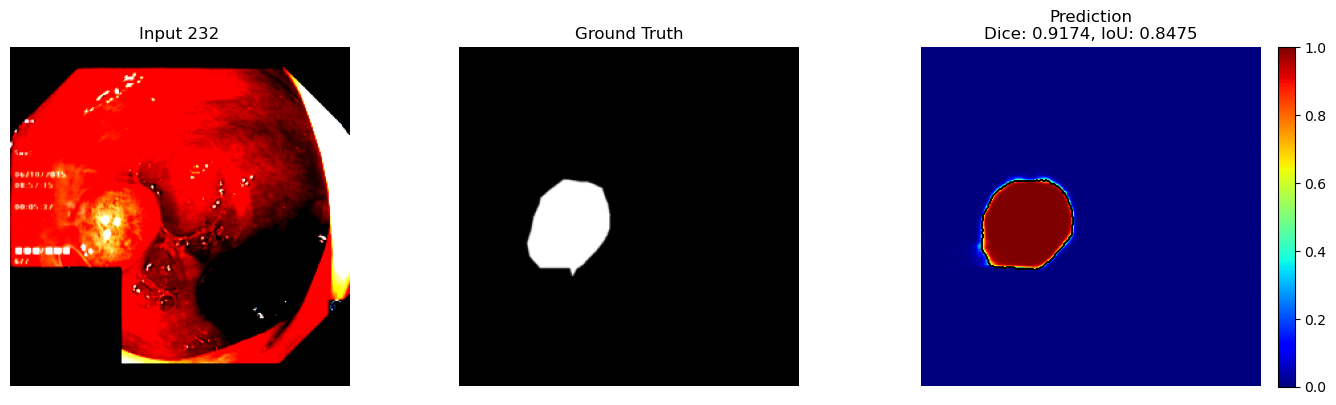

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


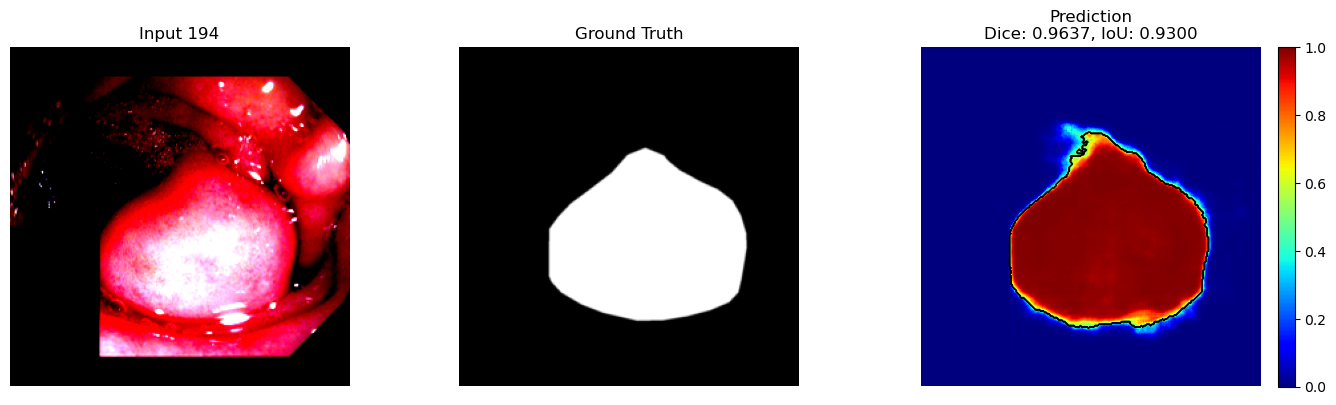

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


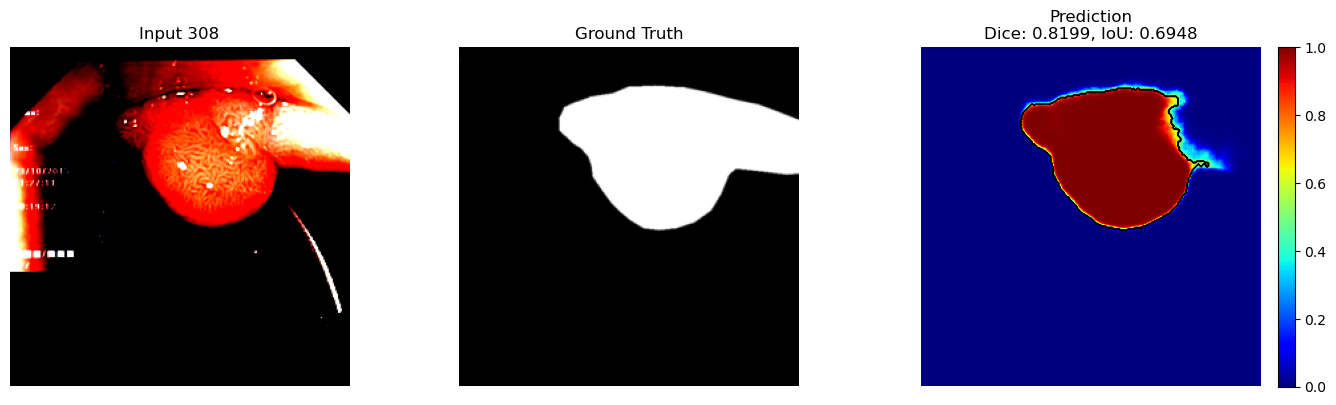

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def dice_score(pred, target, smooth=1e-6):
    pred = pred.astype(np.bool_)
    target = target.astype(np.bool_)
    intersection = np.logical_and(pred, target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1e-6):
    pred = pred.astype(np.bool_)
    target = target.astype(np.bool_)
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    return (intersection + smooth) / (union + smooth)

def visualize_predictions(model, dataset, device, num_samples=4, threshold=0.5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    for idx, data_idx in enumerate(indices):
        image, mask = dataset[data_idx]
        image_input = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(image_input)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()

        image_np = image.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()
        pred_bin = (pred > threshold).astype(np.uint8)

        dice = dice_score(pred_bin, mask_np)
        iou = iou_score(pred_bin, mask_np)

        fig, axs = plt.subplots(1, 3, figsize=(14, 4))

        axs[0].imshow(image_np)
        axs[0].set_title(f"Input {data_idx}")
        axs[0].axis('off')

        axs[1].imshow(mask_np, cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[1].axis('off')

        im = axs[2].imshow(pred, cmap='jet', vmin=0, vmax=1)
        axs[2].contour(pred_bin, colors='black', linewidths=0.5)
        axs[2].set_title(f"Prediction\nDice: {dice:.4f}, IoU: {iou:.4f}")
        axs[2].axis('off')

        cbar = plt.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

visualize_predictions(model, test_dataset, device=config['DEVICE'], num_samples=4)